# 1.First we get the data

In [1]:
# First we map the drive to access the data file
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# We load the data file
import pandas as pd
dataset = pd.read_csv('/content/drive/MyDrive/DSTI/Churn/Bank churn/Bank_churn_dataset.csv')
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# We take our features in a  new dataset. 
# We exclude the three first columns of the original dataset since they are too specific and the last one since it is the label
df = dataset.iloc[:, 3:]
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Analysis of features types
numerical_features = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary']
categorical_features = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
label = ['Exited']

# 2.Split of the data in train/test and preparing the automatic data transformation

In [5]:
# we make the data split between train and test
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)

In [6]:
print(f"The shape of train : {df_train.shape}")
print(f"The shape of test : {df_test.shape}")

The shape of train : (8000, 11)
The shape of test : (2000, 11)


In [7]:
df_train_x = df_train.iloc[:,:-1]
df_train_y = df_train.iloc[:,-1]
df_test_x = df_test.iloc[:,:-1]
df_test_y = df_test.iloc[:,-1]

In [8]:
df_train_x.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2694,628,Germany,Male,29,3,113146.98,2,0,1,124749.08
5140,626,France,Female,29,4,105767.28,2,0,0,41104.82
2568,612,Germany,Female,47,6,130024.87,1,1,1,45750.21
3671,646,Germany,Female,52,6,111739.40,2,0,1,68367.18
7427,714,Spain,Male,33,8,122017.19,1,0,0,162515.17


In [9]:
# we prepare the transformation operations on numerical features and string features in pipelines in order to be able to apply the same transformations for the future model in prediction
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

numerical_pipeline = make_pipeline(SimpleImputer(), StandardScaler())

categorical_pipeline = make_pipeline(SimpleImputer(strategy = 'most_frequent'), OrdinalEncoder())

In [10]:
# we include the transformation operations into a single column transformer. Each transformation applies to the corresponding features
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

preprocessor = make_column_transformer((numerical_pipeline, numerical_features), (categorical_pipeline, categorical_features))

In [11]:
# test of the automatic transformations
preprocessor.fit_transform(df_train_x)


array([[-0.23082038, -0.94449979, -0.70174202, ...,  1.        ,
         1.        ,  1.        ],
       [-0.25150912, -0.94449979, -0.35520275, ...,  0.        ,
         0.        ,  0.        ],
       [-0.3963303 ,  0.77498705,  0.33787579, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 0.22433188,  0.58393295,  1.3774936 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.13123255,  0.01077067,  1.03095433, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.1656695 ,  0.29735181,  0.33787579, ...,  0.        ,
         1.        ,  1.        ]])

# 3.We use the SMOT class in order to complete the unbalanced class Exit = 1

In [12]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
df_train_x_res, df_train_y_res = oversample.fit_resample(preprocessor.fit_transform(df_train_x), df_train_y)

In [13]:
print(f"The shape of resampled train x : {df_train_x_res.shape}")
print(f"The shape of resampled train y : {df_train_y_res.shape}")

The shape of resampled train x : (12756, 10)
The shape of resampled train y : (12756,)


In [14]:
df_train_y_res.value_counts()

0    6378
1    6378
Name: Exited, dtype: int64

We see now that the Exited class has the same number of clients

# 4.Trying the same models

In [15]:
# we have to install scikeras to be able to import the specific modules that have been developped
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
# we declare the path to the specific_modules.py folder in order to be able to load it
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/projet')

In [17]:
# we import one specific class ModelWrapper and one specific function model_nn that will be used for the models processing
from specific_modules import ModelWrapper, model_nn

In [18]:
# we initialize the list of models we will use
list_of_models = []

## 4.1.Model 1 : XGBClassifier

In [19]:
# we try the XGB model with a GridSearchCV to optimize the hyper parameters
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_xgb_grid = {'max_depth': [5,6,7,8], 'gamma': [0.01,0.001],'min_child_weight':[1,5,10], 'learning_rate': [0.05,0.1,0.2], 'n_estimators':[5,10]}
xgb_grid = GridSearchCV(XGBClassifier(), param_grid = param_xgb_grid, cv=5, refit=True, verbose=0)

In [20]:
# we train the model directly on the resampled training data
xgb_grid.fit(df_train_x_res, df_train_y_res)

GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'gamma': [0.01, 0.001],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 6, 7, 8],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [5, 10]})

In [21]:
# we integrate the trained model in the model wrapper
model1 = ModelWrapper(base_preprocessor=preprocessor, base_model = xgb_grid, tag = 'XGBClassifier trained on smot data')

In [22]:
modele1_training_analysis = pd.DataFrame(model1.named_steps['model'].cv_results_)
modele1_training_analysis.sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
67,0.190122,0.004172,0.003505,0.000380,0.01,0.2,8,1,10,"{'gamma': 0.01, 'learning_rate': 0.2, 'max_dep...",0.768025,0.862799,0.880831,0.883967,0.901999,0.859524,0.047410,1
139,0.189136,0.004652,0.003239,0.000161,0.001,0.2,8,1,10,"{'gamma': 0.001, 'learning_rate': 0.2, 'max_de...",0.768025,0.862799,0.880831,0.883967,0.897295,0.858583,0.046597,2
69,0.186851,0.003819,0.003268,0.000044,0.01,0.2,8,5,10,"{'gamma': 0.01, 'learning_rate': 0.2, 'max_dep...",0.765674,0.865935,0.878479,0.869071,0.890239,0.853880,0.044908,3
141,0.183963,0.002716,0.003234,0.000250,0.001,0.2,8,5,10,"{'gamma': 0.001, 'learning_rate': 0.2, 'max_de...",0.765674,0.865935,0.878479,0.869071,0.889455,0.853723,0.044782,4
133,0.164942,0.004826,0.003115,0.000138,0.001,0.2,7,1,10,"{'gamma': 0.001, 'learning_rate': 0.2, 'max_de...",0.761364,0.861623,0.871031,0.866719,0.892983,0.850744,0.045952,5


In [23]:
model1_predictions = model1.predict(df_test_x)

In [24]:
model1.evaluate(y_true = df_test_y, y_pred = model1_predictions)

Confusion matrix : array([[1422,  163],
       [ 142,  273]])
Precision : 0.6261467889908257
Accuracy : 0.8475
Recall : 0.6578313253012048


In [25]:
model1.calculate_roc(y_true = df_test_y, y_score = model1.predict_proba(df_test_x)[:,1])

Roc_auc_score : 0.8639261145528485


In [26]:
list_of_models.append(model1)

## 4.2.Model 2 : Logistic regression

In [27]:
# Fit logistic regression
from sklearn.linear_model import LogisticRegression

param_logistic_grid = {'C': [0.1,0.5,1,10,50,100], 'max_iter': [250], 'fit_intercept':[True],'intercept_scaling':[1],
              'penalty':['l2'], 'tol':[0.00001,0.0001,0.000001]}
logistic_Grid = GridSearchCV(LogisticRegression(solver='lbfgs'),param_grid = param_logistic_grid, cv = 10, refit=True, verbose=0)

In [28]:
# we train the model directly on the resampled training data
logistic_Grid.fit(df_train_x_res, df_train_y_res)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.5, 1, 10, 50, 100],
                         'fit_intercept': [True], 'intercept_scaling': [1],
                         'max_iter': [250], 'penalty': ['l2'],
                         'tol': [1e-05, 0.0001, 1e-06]})

In [29]:
# we integrate the trained model in the model wrapper
model2 = ModelWrapper(base_preprocessor=preprocessor, base_model = logistic_Grid, tag = 'LogisticRegression trained on smot data')

In [30]:
model2_predictions = model2.predict(df_test_x)

In [31]:
model2.evaluate(y_true = df_test_y, y_pred = model2_predictions)

Confusion matrix : array([[1141,  444],
       [ 133,  282]])
Precision : 0.3884297520661157
Accuracy : 0.7115
Recall : 0.6795180722891566


In [32]:
model2.calculate_roc(y_true = df_test_y, y_score = model2.predict_proba(df_test_x)[:,1])

Roc_auc_score : 0.7663410740754817


In [33]:
list_of_models.append(model2)

## 4.3.Model 3 : SVM with Pol Kernel

In [34]:
# Fit SVM
from sklearn.svm import SVC

param_svm_grid = {'C': [0.5,1,10,50,100], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['poly'],'degree':[2,3] }
svm_Grid = GridSearchCV(SVC(),param_grid = param_svm_grid, cv = 3, refit=True, verbose=0)

In [35]:
# we train the model directly on the resampled training data
svm_Grid.fit(df_train_x_res, df_train_y_res)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.5, 1, 10, 50, 100], 'degree': [2, 3],
                         'gamma': [0.1, 0.01, 0.001], 'kernel': ['poly'],
                         'probability': [True]})

In [36]:
model3 = ModelWrapper(base_preprocessor=preprocessor, base_model = svm_Grid, tag = 'SVM trained on smot data')

In [37]:
model3_predictions = model3.predict(df_test_x)

In [38]:
model3.evaluate(y_true = df_test_y, y_pred = model3_predictions)

Confusion matrix : array([[1252,  333],
       [ 109,  306]])
Precision : 0.4788732394366197
Accuracy : 0.779
Recall : 0.7373493975903614


In [39]:
model3.calculate_roc(y_true = df_test_y, y_score = model3.predict_proba(df_test_x)[:,1])

Roc_auc_score : 0.8432138649234161


In [40]:
list_of_models.append(model3)

## 4.4.Model 4 : Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

param_rf_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [2,4,6,7,8,9],'n_estimators':[50,100],'min_samples_split': [3, 5, 6, 7]}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid = param_rf_grid, cv=5, refit=True, verbose=0)

In [42]:
# we train the model directly on the resampled training data
rf_grid.fit(df_train_x_res, df_train_y_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 6, 7, 8],
                         'max_features': [2, 4, 6, 7, 8, 9],
                         'min_samples_split': [3, 5, 6, 7],
                         'n_estimators': [50, 100]})

In [43]:
model4 = ModelWrapper(base_preprocessor=preprocessor, base_model=rf_grid, tag = 'RandomForest trained on smot data')

In [44]:
model4_predictions = model4.predict(df_test_x)

In [45]:
model4.evaluate(y_true = df_test_y, y_pred = model4_predictions)

Confusion matrix : array([[1405,  180],
       [ 148,  267]])
Precision : 0.5973154362416108
Accuracy : 0.836
Recall : 0.6433734939759036


In [46]:
model4.calculate_roc(y_true = df_test_y, y_score = model4.predict_proba(df_test_x)[:,1])

Roc_auc_score : 0.8638447797499146


In [47]:
list_of_models.append(model4)

## 4.5.Model 5 : Neural network

In [48]:
from scikeras.wrappers import KerasClassifier

nn_with_keras = KerasClassifier(model = model_nn, batch_size=100, verbose = 2).set_params(epochs = 200)

In [49]:
nn_with_keras.fit(df_train_x_res, df_train_y_res)

Epoch 1/200
128/128 - 2s - loss: 0.6390 - accuracy: 0.7063 - mean_squared_error: 0.2238 - auc: 0.7359 - 2s/epoch - 14ms/step
Epoch 2/200
128/128 - 0s - loss: 0.5223 - accuracy: 0.7502 - mean_squared_error: 0.1733 - auc: 0.8209 - 281ms/epoch - 2ms/step
Epoch 3/200
128/128 - 0s - loss: 0.4920 - accuracy: 0.7585 - mean_squared_error: 0.1628 - auc: 0.8421 - 328ms/epoch - 3ms/step
Epoch 4/200
128/128 - 0s - loss: 0.4828 - accuracy: 0.7589 - mean_squared_error: 0.1598 - auc: 0.8475 - 315ms/epoch - 2ms/step
Epoch 5/200
128/128 - 0s - loss: 0.4761 - accuracy: 0.7650 - mean_squared_error: 0.1573 - auc: 0.8518 - 317ms/epoch - 2ms/step
Epoch 6/200
128/128 - 0s - loss: 0.4737 - accuracy: 0.7641 - mean_squared_error: 0.1565 - auc: 0.8533 - 344ms/epoch - 3ms/step
Epoch 7/200
128/128 - 0s - loss: 0.4714 - accuracy: 0.7661 - mean_squared_error: 0.1556 - auc: 0.8549 - 311ms/epoch - 2ms/step
Epoch 8/200
128/128 - 0s - loss: 0.4690 - accuracy: 0.7683 - mean_squared_error: 0.1548 - auc: 0.8562 - 344ms/epo

KerasClassifier(
	model=<function model_nn at 0x7ff2890d34d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=100
	validation_batch_size=None
	verbose=2
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=200
	class_weight=None
)

In [50]:
model5 = ModelWrapper(base_preprocessor=preprocessor, base_model=nn_with_keras, tag = 'NeuralNetwork trained on smot data')

In [51]:
model5_predictions = model5.predict(df_test_x)

20/20 - 0s - 231ms/epoch - 12ms/step


In [52]:
model5.evaluate(y_true = df_test_y, y_pred = model5_predictions)

Confusion matrix : array([[1381,  204],
       [ 136,  279]])
Precision : 0.577639751552795
Accuracy : 0.83
Recall : 0.672289156626506


In [53]:
model5.calculate_roc(y_true = df_test_y, y_score = model5.predict_proba(df_test_x)[:,1])

20/20 - 0s - 50ms/epoch - 3ms/step
Roc_auc_score : 0.8460142145870548


In [54]:
list_of_models.append(model5)

# 5.Summary of all models

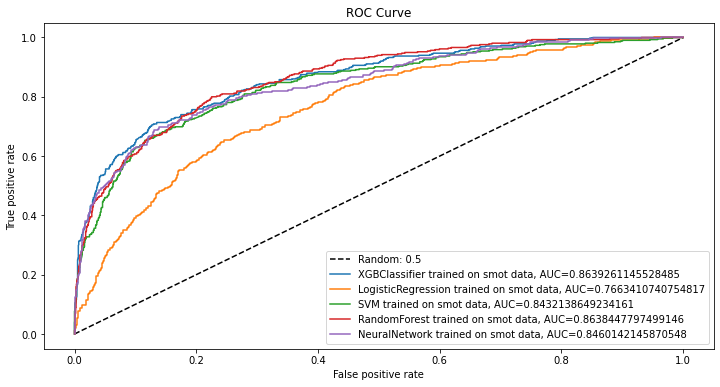

In [56]:
import matplotlib.pyplot as plt
global_report = pd.DataFrame(columns = ['Tag', 'Description' , 'Confusion matrix', 'Accuracy', 'Precision', 'Recall', 'ROC'])

plt.figure(figsize = (12,6), linewidth= 1)
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')

for model in list_of_models:
  global_report = global_report.append(model.get_performances(),ignore_index = True)
  plt.plot(model.fpr, model.tpr, label=str(model.tag) + ", AUC=" + str(model.roc_auc_score))

plt.legend(loc='best')

In [57]:
global_report

,Tag,Description,Confusion matrix,Accuracy,Precision,Recall,ROC
0,XGBClassifier trained on smot data,"GridSearchCV(cv=5, estimator=XGBClassifier(),\...","[[1422, 163], [142, 273]]",0.8475,0.626147,0.657831,0.863926
1,LogisticRegression trained on smot data,"GridSearchCV(cv=10, estimator=LogisticRegressi...","[[1141, 444], [133, 282]]",0.7115,0.388430,0.679518,0.766341
2,SVM trained on smot data,"GridSearchCV(cv=3, estimator=SVC(),\n ...","[[1252, 333], [109, 306]]",0.7790,0.478873,0.737349,0.843214
3,RandomForest trained on smot data,"GridSearchCV(cv=5, estimator=RandomForestClass...","[[1405, 180], [148, 267]]",0.8360,0.597315,0.643373,0.863845
4,NeuralNetwork trained on smot data,KerasClassifier(\n\tmodel=<function model_nn a...,"[[1381, 204], [136, 279]]",0.8300,0.577640,0.672289,0.846014


We can see that after having used SMOT, the best model seems to be the XGBClassifier which presents an increased ROC to 0.86

# 6.Saving the models

In [58]:
import os
import pickle

path_for_models_trained_on_smot_data = '/content/drive/MyDrive/Colab Notebooks/projet/trained models smot/'

for model in list_of_models:
  
  try:
    os.remove(path_for_models_trained_on_smot_data + model.tag + '.sav')
    print(path_for_models_trained_on_smot_data + model.tag + '.sav has been deleted')
  except:
    print(model.tag + ' does not exist')

  with open(path_for_models_trained_on_smot_data + model.tag + '.sav', 'wb') as f:
    
    pickle.dump(model, f)    
    f.close()

    print(path_for_models_trained_on_smot_data + model.tag + '.sav has been saved')

/content/drive/MyDrive/Colab Notebooks/projet/trained models smot/XGBClassifier trained on smot data.sav has been deleted
/content/drive/MyDrive/Colab Notebooks/projet/trained models smot/XGBClassifier trained on smot data.sav has been saved
/content/drive/MyDrive/Colab Notebooks/projet/trained models smot/LogisticRegression trained on smot data.sav has been deleted
/content/drive/MyDrive/Colab Notebooks/projet/trained models smot/LogisticRegression trained on smot data.sav has been saved
/content/drive/MyDrive/Colab Notebooks/projet/trained models smot/SVM trained on smot data.sav has been deleted
/content/drive/MyDrive/Colab Notebooks/projet/trained models smot/SVM trained on smot data.sav has been saved
/content/drive/MyDrive/Colab Notebooks/projet/trained models smot/RandomForest trained on smot data.sav has been deleted
/content/drive/MyDrive/Colab Notebooks/projet/trained models smot/RandomForest trained on smot data.sav has been saved
/content/drive/MyDrive/Colab Notebooks/proje

In [59]:
!pip freeze requirements.txt

absl-py==1.3.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.2.0
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==3.0.0
autograd==1.5
Babel==2.10.3
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.8
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.8
certifi==2022.9.24
cffi==1.15.1
cftime==1.6.2
chardet==3.0.4
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==1.5.0
cmake==3.22.6
cmdstanpy==1.0.7
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.3
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.32
daft==0.0.4
dask==2022.2.0
datascience==0.17.5
debugpy==1.0.0
decorator==4.4.